## QUANTUM AUTOENCODER ##

In [1]:
import time
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
import csv
from pennylane import numpy

/Users/edoardozappia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def ansatz(params, n_wires_latent, n_wires_trash):
    init_weights = params[:5]
    init_weights = qml.numpy.tensor(init_weights, requires_grad=True)
    weights = params[5:]
    weights = np.reshape(weights, (2, 4, 2))
    weights = qml.numpy.tensor(weights, requires_grad=True)
    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(n_wires_latent+n_wires_trash))

In [3]:
def swap_test(num_latent, num_trash):
    auxiliary_qubit = num_latent + 2 * num_trash
    qml.Hadamard(auxiliary_qubit)
    for i in range(num_trash):
        qml.CSWAP(wires=[auxiliary_qubit, num_latent + i, num_latent + num_trash + i])
    qml.Hadamard(auxiliary_qubit)

In [4]:
n_wires_latent = 3
n_wires_trash = 2
n_wires_total = n_wires_latent + 2 * n_wires_trash +1

In [5]:
dev = qml.device("default.qubit", wires=n_wires_total)

In [6]:
def quantum_encoder_train(init_weights, weights, n_wires_latent, n_wires_trash):
    ansatz(init_weights, weights)
    swap_test(n_wires_latent, n_wires_trash)

In [6]:
def quantum_encoder_train(params, n_wires_latent, n_wires_trash):
    ansatz(params,n_wires_latent, n_wires_trash)
    swap_test(n_wires_latent, n_wires_trash)
    

In [7]:
@qml.qnode(dev)
def domain_wall(params):
    # Separare i parametri
    #init_weights = params[:5]
    #init_weights = qml.numpy.tensor(init_weights, requires_grad=True)
    #weights = params[5:]
    #weights = np.reshape(weights, (2, 4, 2))
    #weights = qml.numpy.tensor(weights, requires_grad=True)
    qml.X(2)
    qml.X(3)
    qml.X(4)
    quantum_encoder_train(params, n_wires_latent, n_wires_trash)
    # n_wires_latent and n_wires_trash are global variables
    #quantum_encoder_train(init_weights, weights, n_wires_latent, n_wires_trash)
    return qml.probs(wires=7)#, op=qml.PauliZ(7))
    #return qml.expval(qml.Z(7))

In [8]:
initial_point = np.random.random((5,))
print(np.shape(initial_point))
initial_point = qml.numpy.tensor(initial_point, requires_grad=True)
weights = np.random.random((2, 4, 2))
weights = qml.numpy.tensor(weights, requires_grad=True)
print(np.shape(weights))
print(weights)
params = np.concatenate([initial_point, weights.flatten()])
params = qml.numpy.tensor(params, requires_grad=True)
print(params)
print(params[:5])

(5,)
(2, 4, 2)
[[[0.24376824 0.62875389]
  [0.17683617 0.96155574]
  [0.2104497  0.24572815]
  [0.12023762 0.80544149]]

 [[0.9637335  0.37060194]
  [0.40426568 0.13121233]
  [0.77842434 0.08747317]
  [0.08599867 0.61976986]]]
[0.87604688 0.18931248 0.69828943 0.01588101 0.65848775 0.24376824
 0.62875389 0.17683617 0.96155574 0.2104497  0.24572815 0.12023762
 0.80544149 0.9637335  0.37060194 0.40426568 0.13121233 0.77842434
 0.08747317 0.08599867 0.61976986]
[0.87604688 0.18931248 0.69828943 0.01588101 0.65848775]


(<Figure size 800x900 with 1 Axes>, <Axes: >)


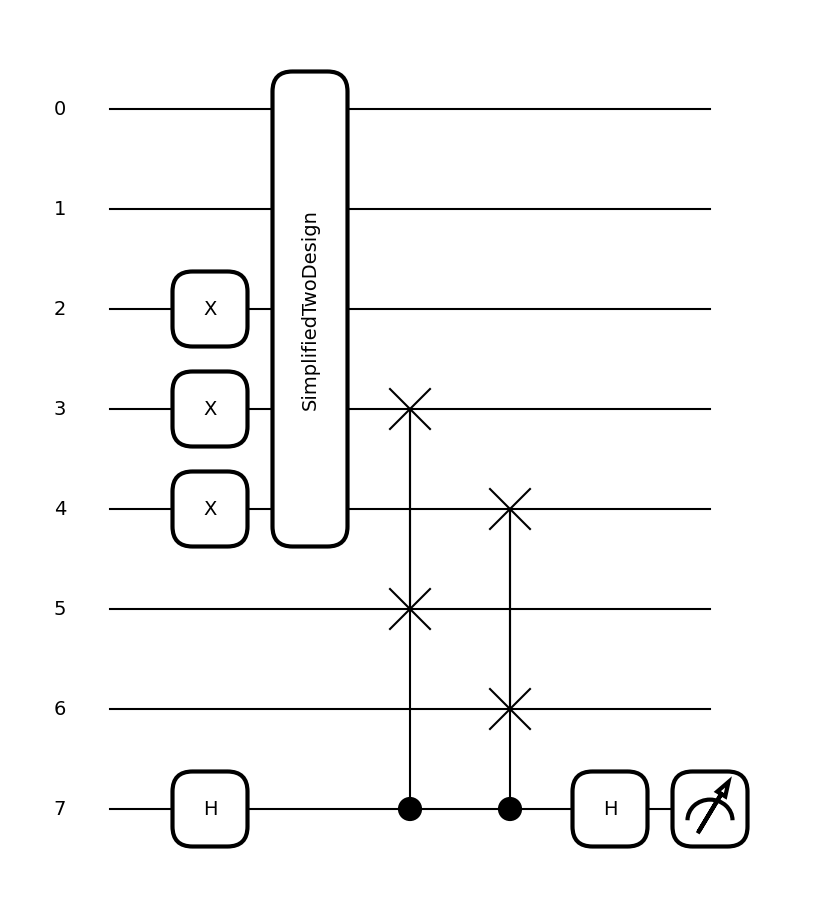

In [9]:
drawer = qml.draw_mpl(domain_wall)
print(drawer(params))

In [10]:
# Definizione della funzione di costo come la somma delle probabilità di misurare 1
def cost_function(params):
    
    # Ottiene le probabilità di misurazione
    probs = domain_wall(params)
    print(f"Probabilities: {probs}")
    
    # La funzione di costo è la somma delle probabilità di ottenere 1
    cost = probs[1]  # Assumendo che prob[1] rappresenti la probabilità di misurare 1
    print(f"Probability of measuring 1: {cost}")
    return cost


In [11]:
# Inizializzazione dell'ottimizzatore
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 150
costs = []

# Ciclo di addestramento
start = time.time()
for i in range(steps):
    params, cost_val = opt.step_and_cost(cost_function, params)
    costs.append(cost_val)
    if i%5==0:
        print(f"Step {i+1}: cost = {cost_val:.4f}")

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")
# Stampa dei pesi ottimizzati
print("Pesi ottimizzati:", params)
opt_weights = params

Probabilities: Autograd ArrayBox with value [0.57450114 0.42549886]
Probability of measuring 1: Autograd ArrayBox with value 0.42549885807747656
Step 1: cost = 0.4255
Probabilities: Autograd ArrayBox with value [0.5795459 0.4204541]
Probability of measuring 1: Autograd ArrayBox with value 0.42045409512527493
Probabilities: Autograd ArrayBox with value [0.58493471 0.41506529]
Probability of measuring 1: Autograd ArrayBox with value 0.41506529321405833
Probabilities: Autograd ArrayBox with value [0.59068612 0.40931388]
Probability of measuring 1: Autograd ArrayBox with value 0.40931388364278143
Probabilities: Autograd ArrayBox with value [0.59681841 0.40318159]
Probability of measuring 1: Autograd ArrayBox with value 0.40318158672488313
Probabilities: Autograd ArrayBox with value [0.60334923 0.39665077]
Probability of measuring 1: Autograd ArrayBox with value 0.39665076646435743
Step 6: cost = 0.3967
Probabilities: Autograd ArrayBox with value [0.61029514 0.38970486]
Probability of measu

In [12]:
print(opt_weights)

[ 0.88123083  0.15490137  0.25751106 -0.72961875  0.81836426  0.24376824
  0.58383815  0.30257349  1.91380879  0.2104497   0.26683894 -0.14292942
  1.27484505  0.9637335   0.37060194  0.40426568  0.42536036  0.77842434
  0.08747317 -0.41484436  1.15726983]


In [13]:
# Salva i pesi ottimizzati in un file CSV
with open("optimized_weights.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Peso"])
    writer.writerows([[weight] for weight in weights])


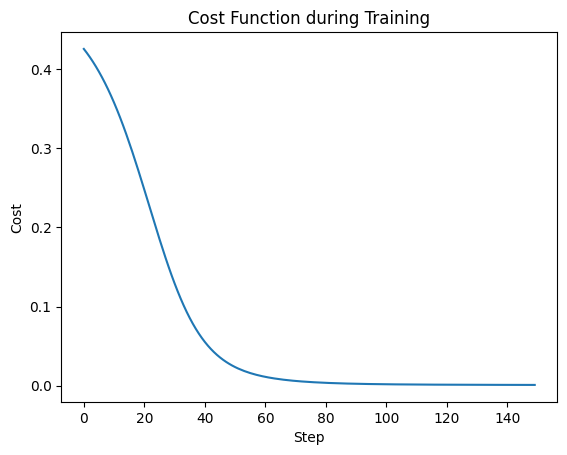

In [14]:
# Traccia la funzione di perdita durante l'addestramento
plt.plot(costs)
plt.xlabel('Step')
plt.ylabel('Cost')
plt.title('Cost Function during Training')
plt.show()

In [15]:
dev_autoencoder = qml.device("default.qubit", wires=n_wires_latent+n_wires_trash)

In [41]:
def reset_to_zero(wir):
    m = qml.measure(wir[0])
    m = qml.measure(wir[1])
    qml.cond(m, qml.PauliX)(wir[0])
    qml.cond(m, qml.PauliX)(wir[1])

In [42]:
@qml.qnode(dev_autoencoder)
def autoencoder(opt_weights):   
    domain_wall(opt_weights)
    wir=[3, 4]
    reset_to_zero(wir)
    qml.adjoint(quantum_encoder_train)(opt_weights, n_wires_latent, n_wires_trash)
    return qml.state()

/Users/edoardozappia/Library/Python/3.9/lib/python/site-packages/pennylane/drawer/mpldrawer.py:634: UserWarning: Some control indicators are hidden behind an operator. Consider re-ordering your circuit wires to ensure all control indicators are visible.
  warnings.warn(


(<Figure size 1900x975 with 1 Axes>, <Axes: >)


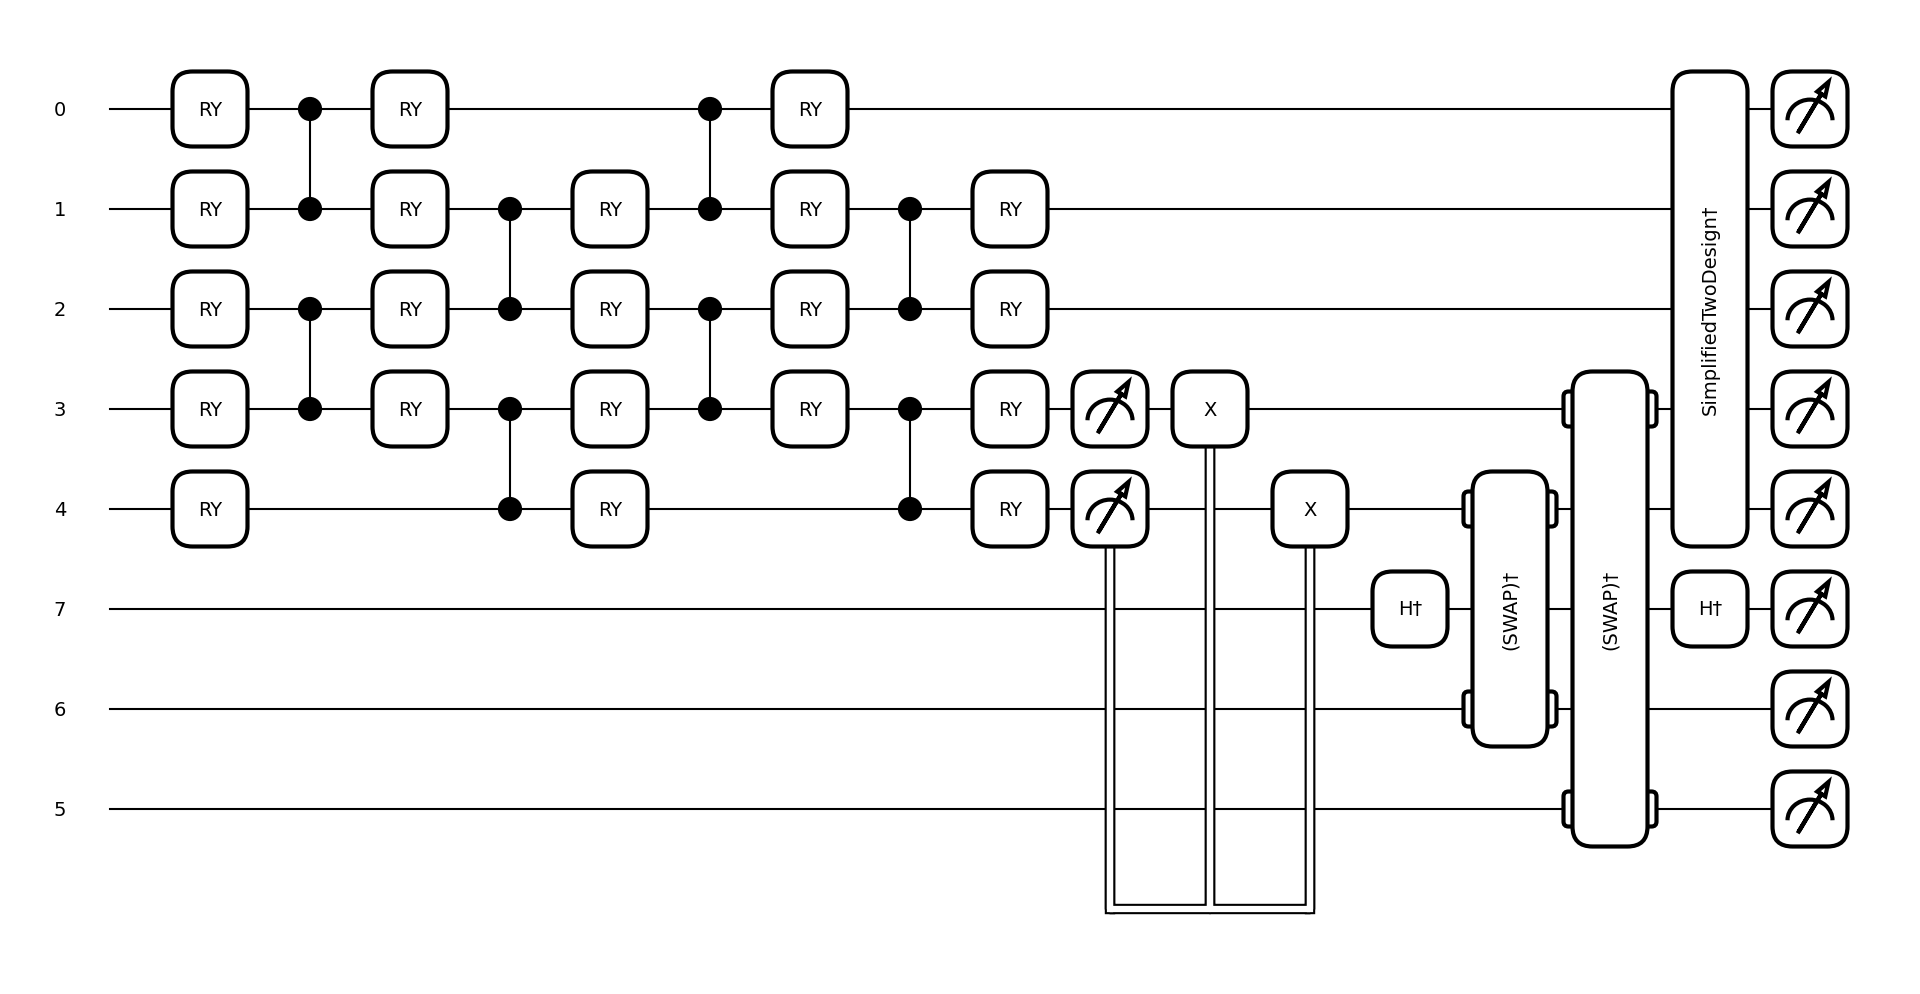

In [43]:
drawer_1 = qml.draw_mpl(autoencoder)
print(drawer_1(opt_weights))

In [21]:
dev_initial = qml.device("default.qubit", wires=5)
@qml.qnode(dev_initial)
def initial_state():
    qml.X([2, 3, 4])

test_state = ()
fidelity = np.abs(np.dot(domain_wall_state.conj(), test_state))**2
print("Fidelity of our Output State with our Input State: ", fidelity)

NameError: name 'domain_wall_state' is not defined

In [29]:
dev_prova = qml.device("default.qubit", wires=1)
@qml.qnode(dev_prova)
def circ():
    qml.Hadamard(wires=0)
    reset_to_zero()
    return qml.probs(wires=0)